# Download the PaleoCAR data files

### Get list of NetCDF files in dataset directory on NOAA web site

In [1]:
import ipywidgets as widgets
from IPython.display import  HTML
import os.path
import pandas as pd
import requests
import osr
import numpy as np
from osgeo import gdal
import affine
import matplotlib.pyplot as plt

### Define url of directory at NOAA containing the data files to download

In [2]:
dataset_url = 'http://www1.ncdc.noaa.gov/pub/data/paleo/treering/reconstructions/northamerica/usa/bocinsky2016/'
default_destination_dir = '/projects/skope/original/paleocar/'

### Get the names of files corresponding to each of the two data set variables

In [3]:
# load first html table at url into a dataframe
table = pd.read_html(dataset_url)[0]

# discard table rows with nulls in column 1
valid_rows = table.dropna(subset=[1])

# get column of file names
file_names = valid_rows[1]

# get names of files corresponding to the GDD and PPT variables
gdd_file_names = list(file_names[file_names.str.contains('GDD.nc4')])
ppt_file_names = list(file_names[file_names.str.contains('PPT.nc4')])

gdd_total_file_count = len(gdd_file_names)
ppt_total_file_count = len(ppt_file_names)

# make sure there are 155 files for each variable
assert gdd_total_file_count == 155
assert ppt_total_file_count == 155

### Specify the number of files to download for each variable

In [4]:
download_to_directory = widgets.Text(
    description = "Download to", value=default_destination_dir)

gdd_selected_file_count = widgets.IntSlider(
    description = "GDD files", 
    min         = 1, 
    max         = gdd_total_file_count, 
    value       = gdd_total_file_count
)

ppt_selected_file_count = widgets.IntSlider(
    description = "PPT files", 
    min         = 1, 
    max         = ppt_total_file_count, 
    value       = ppt_total_file_count
)

download_status = widgets.Button(
    description = 'Download not started',
    disabled    = True
)

display(
    download_to_directory,
    gdd_selected_file_count, 
    ppt_selected_file_count, 
    download_status
)

Text(value='/projects/skope/original/paleocar/', description='Download to')

IntSlider(value=155, description='GDD files', max=155, min=1)

IntSlider(value=155, description='PPT files', max=155, min=1)

Button(description='Download not started', disabled=True, style=ButtonStyle())

### Download the selected number of files for each variable of the dataset

In [5]:
destination_dir = download_to_directory.value

def download_file(source_url, destination_path):
    response = requests.get(source_url)
    assert response.status_code == 200
    with open(destination_path, 'wb') as f:  
        f.write(response.content)

def download_file_if_needed(base_url, file_name, destination_dir):
    source_url = base_url + file_name
    destination_path = destination_dir + '/' + file_name
    if os.path.exists(destination_path):
        print(file_name, "already downloaded")
    else:
        download_file(source_url, destination_path)
        print(file_name, "finished downloading")

def download_files(file_list, destination_dir):
    for i, file_name in enumerate(file_list):
        download_file_if_needed(dataset_url, file_name, destination_dir)
    print("\nTotal of %d files downloaded\n" % (i+1))

download_status.description = 'Downloading files'
download_files(gdd_file_names[:gdd_selected_file_count.value], destination_dir)
download_files(ppt_file_names[:ppt_selected_file_count.value], destination_dir)
download_status.description = 'Downloads complete'


103W31N_GDD.nc4 already downloaded
103W32N_GDD.nc4 already downloaded
103W33N_GDD.nc4 already downloaded
103W34N_GDD.nc4 already downloaded
103W35N_GDD.nc4 already downloaded
103W36N_GDD.nc4 already downloaded
103W37N_GDD.nc4 already downloaded
103W38N_GDD.nc4 already downloaded
103W39N_GDD.nc4 already downloaded
103W40N_GDD.nc4 already downloaded
103W41N_GDD.nc4 already downloaded
103W42N_GDD.nc4 already downloaded
104W31N_GDD.nc4 already downloaded
104W32N_GDD.nc4 already downloaded
104W33N_GDD.nc4 already downloaded
104W34N_GDD.nc4 already downloaded
104W35N_GDD.nc4 already downloaded
104W36N_GDD.nc4 already downloaded
104W37N_GDD.nc4 already downloaded
104W38N_GDD.nc4 already downloaded
104W39N_GDD.nc4 already downloaded
104W40N_GDD.nc4 already downloaded
104W41N_GDD.nc4 already downloaded
104W42N_GDD.nc4 already downloaded
105W31N_GDD.nc4 already downloaded
105W32N_GDD.nc4 already downloaded
105W33N_GDD.nc4 already downloaded
105W34N_GDD.nc4 already downloaded
105W35N_GDD.nc4 alre

# Display properties of the first downloaded data file

### Load the first GDD data file into a GDAL dataset object

In [6]:
# get path to first GDD data file
path_to_first_gdd_file = destination_dir + "/" + gdd_file_names[0]

# open the first GDD data file
dataset = gdal.Open(path_to_first_gdd_file)

# confirm that a Dataset object was returned
assert str((type(dataset))) == "<class 'osgeo.gdal.Dataset'>"

### Confirm that dimensions of data set is 120 x 120 pixels and 2000 bands

In [7]:
# extract the dimensions from the data file 
extent_in_pixels_x = dataset.RasterXSize
extent_in_pixels_y = dataset.RasterYSize
band_count         = dataset.RasterCount

# confirm the dimensions are those expected
assert extent_in_pixels_x == 120
assert extent_in_pixels_y == 120
assert band_count         == 2000

# summarize the data file dimensions
print('Dimensions: %d x %d pixels and %d bands' % (
    extent_in_pixels_x, 
    extent_in_pixels_y, 
    band_count
    )
)

Dimensions: 120 x 120 pixels and 2000 bands


### Load and display elements of the GDAL raster-to-projection coordinate transform

In [8]:
# get the transform from the data file
gt = dataset.GetGeoTransform()

# confirm that this indeed is a North-Up transformation, i.e. that
#    ignored elements of transform are both zero
assert gt[2] == 0
assert gt[4] == 0

# extract the origin and pixel dimensions from the transform
origin_x      = gt[0]
origin_y      = gt[3]
pixel_size_x  = abs(gt[1])
pixel_size_y  = abs(gt[5])

# summarize the transform
print("Origin:          %11.6f,%11.6f" % (origin_x, origin_y))
print("Pixel size:      %11.6f,%11.6f" % (pixel_size_x, pixel_size_y))
print("Pixels/degree:   %11.6f,%11.6f" % (1.0/pixel_size_x, 1.0/pixel_size_y))

Origin:          -102.995833,  31.995833
Pixel size:         0.008333,   0.008333
Pixels/degree:    120.000000, 120.000000


### Compute projection coordinates corresponding to centers of upper left and lower right corner pixels

In [9]:
# center of upper left corner is at raster-space coordinates (0.5,0.5)
pixel_x = 0.5
pixel_y = 0.5

projected_x = gt[0] + pixel_x * gt[1] + pixel_y * gt[2];
projected_y = gt[3] + pixel_x * gt[4] + pixel_y * gt[5];

print("Center of upper left pixel: %11.6f,%11.6f" % (projected_x, projected_y))

Center of upper left pixel: -102.991667,  31.991667


In [10]:
# center of lower right corner is at raster-space coordinates (119.5,119.5)
pixel_x = 119.5
pixel_y = 119.5

projected_x = gt[0] + pixel_x * gt[1] + pixel_y * gt[2];
projected_y = gt[3] + pixel_x * gt[4] + pixel_y * gt[5];

print("Center of lower corner pixel: %11.6f,%11.6f" % (projected_x, projected_y))

Center of lower corner pixel: -102.000000,  31.000000


### Construct the affine matrix and inverse for converting between raster and projection coordinates

In [11]:
# compute the full affine coordinate transformation matrix from the 6-element GDAL geotransform
affine_matrix = affine.Affine.from_gdal(gt[0], gt[1], gt[2], gt[3], gt[4], gt[5])

# compute the inverse affine transformation matrix
inverse_affine = ~affine_matrix

### Upper left corner (origin)

In [12]:
print('pixel: %12.6f, %12.6f' % ( inverse_affine * (-102.995833334, 31.995833334) ))
print('proj : %12.6f, %12.6f' % ( affine_matrix  * (0, 0)                         ))

pixel:     0.000000,     0.000000
proj :  -102.995833,    31.995833


### Center of upper-left corner pixel

In [13]:
print('rast: %12.6f, %12.6f' % ( inverse_affine * (-103, 32) ))
print('proj: %12.6f, %12.6f' % ( affine_matrix  * (0.5, 0.5) ))

rast:    -0.500000,    -0.500000
proj:  -102.991667,    31.991667


### Center of lower-right corner pixel

In [14]:
print('rast: %12.6f, %12.6f' % ( inverse_affine * (-102, 31)     ))
print('proj: %12.6f, %12.6f' % ( affine_matrix  * (119.5, 119.5) ))

rast:   119.500000,   119.500000
proj:  -102.000000,    31.000000


### Lower-right corner

In [15]:
print('rast: %12.6f, %12.6f' % ( inverse_affine * (-101.995833, 30.995833) ))
print('proj: %12.6f, %12.6f' % ( affine_matrix  * (120, 120)               ))

rast:   120.000040,   120.000040
proj:  -101.995833,    30.995833


### For comparison display output of gdalinfo

In [16]:
!gdalinfo $path_to_first_gdd_file -nomd | head -12

Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Driver: netCDF/Network Common Data Format
Files: /projects/skope/original/paleocar//103W31N_GDD.nc4
Size is 120, 120
Coordinate System is `'
Origin = (-102.995833333999997,31.995833334000000)
Pixel Size = (0.008333333333333,-0.008333333333333)
Corner Coordinates:
Upper Left  (-102.9958333,  31.9958333) 
Lower Left  (-102.9958333,  30.9958333) 
Upper Right (-101.9958333,  31.9958333) 
Lower Right (-101.9958333,  30.9958333) 
Center      (-102.4958333,  31.4958333) 


### Note that the GetProjection() method returns an empty string for this data file

In [17]:
print("Value returned from GetProjection() method on dataset: '%s'" % (
    dataset.GetProjection())
)

assert str(type(dataset.GetProjection())) == "<class 'str'>"
assert dataset.GetProjection()            == ''

Value returned from GetProjection() method on dataset: ''


### Get metadata dictionary from data file

In [18]:
metadata = dataset.GetMetadata_Dict()
metadata_df = pd.DataFrame.from_dict(dataset.GetMetadata_Dict(), 'index')
pd.set_option('display.max_colwidth',100)
HTML(metadata_df.to_html(header=False,justify='left'))

GDD#long_name,May-September Fahrenheit growing-degree days
GDD#projection,"+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"
GDD#projection_format,PROJ.4
GDD#units,"Fahrenheit GDDs, base 10°C, cap 30°C"
GDD#_FillValue,-32768
latitude#long_name,latitude
latitude#units,degrees_north
longitude#long_name,longitude
longitude#units,degrees_east
NC_GLOBAL#author,R. Kyle Bocinsky
NC_GLOBAL#citation,"R. Kyle Bocinsky, Johnathan Rush, Keith W. Kintigh, and Timothy A. Kohler, (2015). Macrohistory ..."


### Extract key metadata elements

In [19]:
variable_name        = metadata['GDD#long_name']
variable_description = metadata['NC_GLOBAL#description']
variable_units       = metadata['GDD#units']
variable_projection  = metadata['GDD#projection']
variable_fillvalue   = metadata['GDD#_FillValue']

print('Name        : %s' % (variable_name))
print('Units       : %s' % (variable_units))
print('Projection  : %s' % (variable_projection))
print('Fill value  : %s' % (variable_fillvalue))
print('Description : %s' % (variable_description))


Name        : May-September Fahrenheit growing-degree days
Units       : Fahrenheit GDDs, base 10°C, cap 30°C
Projection  : +proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs
Fill value  : -32768
Description : Reconstruction of growing-season (May-September) growing degree days in the southwestern United States from tree-rings, AD 1-2000, using the PaleoCAR method.


# Analyze first band of first downloaded data file

### Display properties of the first band

In [20]:
# get the first band
band = dataset.GetRasterBand(1)

# print out key properties of the band
print('width in pixels      : %d' % (band.XSize))
print('height in pixels     : %d' % (band.YSize))
print('block size           : %s' % (band.GetBlockSize()))
print('units                : %s' % (band.GetUnitType()))
print('data type            : %s' % (gdal.GetDataTypeName(band.DataType)))
print('data type size (bits): %s' % gdal.GetDataTypeSize(band.DataType))
print('nodata value         : %d' % (band.GetNoDataValue()))

width in pixels      : 120
height in pixels     : 120
block size           : [120, 120]
units                : Fahrenheit GDDs, base 10°C, cap 30°C
data type            : Int16
data type size (bits): 16
nodata value         : -32768


### Access pixel values in band as a numpy array

In [21]:
# get band pixel values as a numpy array
band_1_array = band.ReadAsArray()
display(band_1_array)

array([[4176, 4155, 4157, ..., 3479, 3471, 3501],
       [4177, 4160, 4147, ..., 3415, 3505, 3406],
       [4152, 4164, 4171, ..., 3475, 3477, 3472],
       ...,
       [3882, 3940, 3940, ..., 4198, 4204, 4181],
       [3906, 3908, 3863, ..., 4200, 4199, 4198],
       [3980, 3918, 4046, ..., 4206, 4218, 4203]], dtype=int16)

### Display statistics for first band

In [22]:
print('min  : %d' % (np.amin(band_1_array)))
print('max  : %d' % (np.amax(band_1_array)))
print('mean : %d' % (np.mean(band_1_array)))

min  : 3285
max  : 4515
mean : 4164


### Render first band as a contour plot

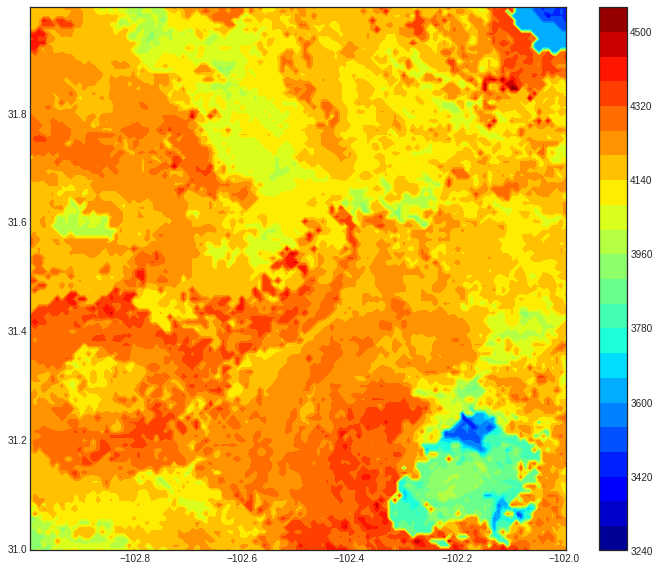

In [23]:
%matplotlib inline
plt.style.use('seaborn-white')

x = np.linspace(origin_x, origin_x + 1, 120)
y = np.linspace(origin_y, origin_y - 1, 120)
fig = plt.figure(figsize=(12,10))
X, Y = np.meshgrid(x, y)
plt.contourf( X, Y, band_1_array, 20, cmap='jet')
plt.colorbar();